# Assign RegulatoryOverlayUUIDs Values to Water Right sites.csv
Purpose:  To assign RegulatoryOverlayUUIDs values to state water right sites.csv File.

Notes: 
- requires the completed pre-processed sites.csv & watersource.csv files from the state "WaterAllocation/ProcessedInputData" folder to be copied over to the "Regulatory/ProcessedInputData" folder.  Rename to wr_sites.csv & wr_watersource.csv to preserve inputs.
- requires awareness of unique WaterSourceTypeCV of each water right site match up to corresponding WaterSourceTypeCV of regulatoryoverlays per reportingunits

In [1]:
# Needed Libraries / Modules

# ---- working with data ----
import os  # native operating system interaction
import numpy as np  # mathematical array manipulation
import pandas as pd  # data structure and data analysis
import geopandas as gpd  # geo-data structure and data analysis

# ---- visualization ----
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# ---- API data retrieval ----
import requests  # http requests
import json  # JSON parse

# ---- Cleanup ----
import re  # string regular expression manipulation
from datetime import datetime  # date and time manipulation
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation in Pandas

In [2]:
# ---- working directory ----
workingDirString = "G:/Shared drives/WaDE Data/Oregon/Regulatory" # set working directory folder string here
os.chdir(workingDirString)
print(f'The working Directory is:', workingDirString)

The working Directory is: G:/Shared drives/WaDE Data/Oregon/Regulatory


## Input Data

In [3]:
# Regulatory Input Data
dfro = pd.read_csv("ProcessedInputData/regulatoryoverlays.csv")
dfru = pd.read_csv("ProcessedInputData/reportingunits.csv")
dfrru = pd.read_csv("ProcessedInputData/regulatoryreportingunits.csv")

# Water right Input Data
dfws = pd.read_csv('ProcessedInputData/wr_watersources.csv')
dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', error_bad_lines=False)

C:\Users\rjame\AppData\Local\Temp\ipykernel_19840\3423606318.py:8: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', error_bad_lines=False)
C:\Users\rjame\AppData\Local\Temp\ipykernel_19840\3423606318.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', error_bad_lines=False)


In [4]:
#### regulatory watersource info with reporting unit info

# merge regulatoryoverlays -to- regulatoryreportingunits -to- reportingunits
dfro = pd.merge(dfro[['RegulatoryOverlayUUID', 'WaterSourceTypeCV']], dfrru[['RegulatoryOverlayUUID', 'ReportingUnitUUID']], left_on='RegulatoryOverlayUUID', right_on='RegulatoryOverlayUUID', how='left')
dfru = pd.merge(dfru, dfro, left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')

print(dfru['ReportingUnitTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(dfru['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfru))
dfru.head(1)

['Administrative Basins']
['Surface and Ground Water']
18


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,ORre_RUor1,4326,North Coast,or1,9.60000,Administrative Basins,9/22/2021,OR,POLYGON ((-123.50593382709745 46.2351311106205...,ORre_ROor1,Surface and Ground Water


In [5]:
#### water right watersource info with site info

# explode site.csv on WaterSourceUUIDs
dfs = dfs.assign(WaterSourceUUIDs=dfs['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# merge watersources to dfs via WaterSourceUUIDs -to -WaterSourceUUID
dfs = pd.merge(dfs, dfws[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(dfs['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfs))
dfs.head(1)

['Groundwater' 'Surface Water' 'Storage' 'WaDE Blank']
193681


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,ORwr_SPOD10000,NaN,ORwr_WSwadeID315,WaDE Blank,WaDE Blank,WaDE Blank,4326,NaN,NaN,NaN,NaN,45.20715,-123.05841,NaN,NaN,POD,WaDE Blank,POD10000,NaN,well,OR,NaN,ORwr_WSwadeID315,Groundwater


## Extract RegulatoryOverlay from Reporting Units and assing to WR Sites
- repeat scripts based on the number of ReportingUnitTypeCV types.
- merge all geo-dataframes into one output

#### Regulatory Area Data #1

In [6]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru1 = dfru.copy()
nameOfReportingUnitTypeVar = "Administrative Basins" # change here for ReportingUnitTypeCV of interest
dfru1 = dfru1[dfru1['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru1))
print(dfru1['WaterSourceTypeCV'].unique())
dfru1.head(1)

18
['Surface and Ground Water']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,ORre_RUor1,4326,North Coast,or1,9.60000,Administrative Basins,9/22/2021,OR,POLYGON ((-123.50593382709745 46.2351311106205...,ORre_ROor1,Surface and Ground Water


<GeoAxesSubplot: >

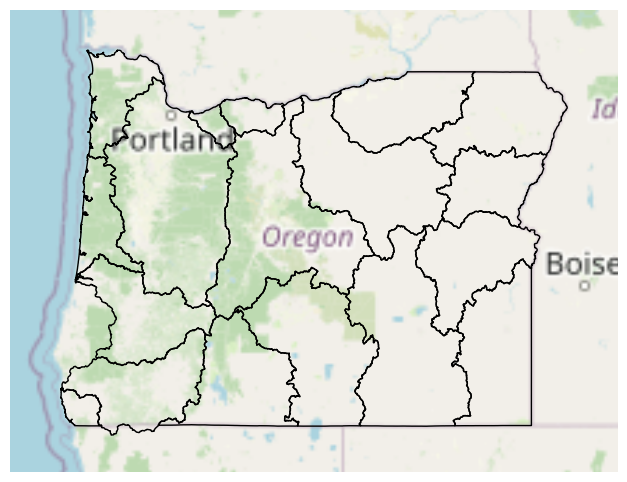

In [7]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru1 = dfru1[dfru1['Geometry'] != ""].reset_index(drop=True)
dfru1['Geometry'] = gpd.GeoSeries.from_wkt(dfru1['Geometry'], crs="EPSG:4326")
gdfru1 = gpd.GeoDataFrame(dfru1, geometry=dfru1['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru1, ax=ax)

In [8]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs1 = dfs.copy()
nameOfWaterSourceTypeCV= "WaDE Blank" # change here for WaterSourceTypeCV of interest
dfs1 = dfs1[dfs1['WaterSourceTypeCV'] != nameOfWaterSourceTypeCV]
dfs1 = dfs1[dfs1['PODorPOUSite'] == 'POD']
print(len(dfs1))
print(dfs1['WaterSourceTypeCV'].unique())
dfs1.head(1)

81957
['Groundwater' 'Surface Water' 'Storage']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,ORwr_SPOD10000,NaN,ORwr_WSwadeID315,WaDE Blank,WaDE Blank,WaDE Blank,4326,NaN,NaN,NaN,NaN,45.20715,-123.05841,NaN,NaN,POD,WaDE Blank,POD10000,NaN,well,OR,NaN,ORwr_WSwadeID315,Groundwater


<GeoAxesSubplot: >

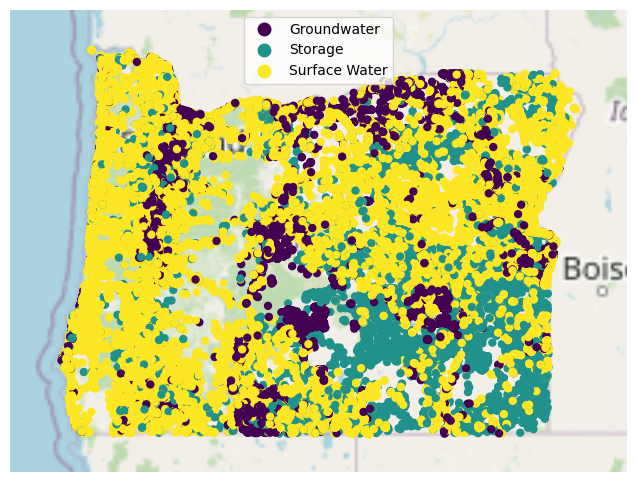

In [9]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs1 = gpd.GeoDataFrame(dfs1, geometry=gpd.points_from_xy(dfs1.Longitude.astype(float), dfs1.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [10]:
# Select sites within polygon.
gdfs1_ru1 = gpd.sjoin(left_df=gdfs1, right_df=gdfru1[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs1_ru1))
gdfs1_ru1.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


78952


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
0,ORwr_SPOD10000,,ORwr_WSwadeID315,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,45.20715,-123.05841,,,POD,WaDE Blank,POD10000,,well,OR,,ORwr_WSwadeID315,Groundwater,POINT (-123.05841 45.20715),10,ORre_RUor2,ORre_ROor2
17,ORwr_SPOD100039,,ORwr_WSwadeID70,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,45.07585,-123.10284,,,POD,WaDE Blank,POD100039,,stream,OR,,ORwr_WSwadeID70,Storage,POINT (-123.10284 45.07585),10,ORre_RUor2,ORre_ROor2
18,ORwr_SPOD100040,,ORwr_WSwadeID15,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,45.07585,-123.10284,,,POD,WaDE Blank,POD100040,,stream,OR,,ORwr_WSwadeID15,Surface Water,POINT (-123.10284 45.07585),10,ORre_RUor2,ORre_ROor2
19,ORwr_SPOD100041,,ORwr_WSwadeID11650,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,45.07723,-123.10461,,,POD,WaDE Blank,POD100041,,reservoir,OR,,ORwr_WSwadeID11650,Surface Water,POINT (-123.10461 45.07723),10,ORre_RUor2,ORre_ROor2
20,ORwr_SPOD100042,,ORwr_WSwadeID70,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,45.07585,-123.10284,,,POD,WaDE Blank,POD100042,,stream,OR,,ORwr_WSwadeID70,Storage,POINT (-123.10284 45.07585),10,ORre_RUor2,ORre_ROor2


<GeoAxesSubplot: >

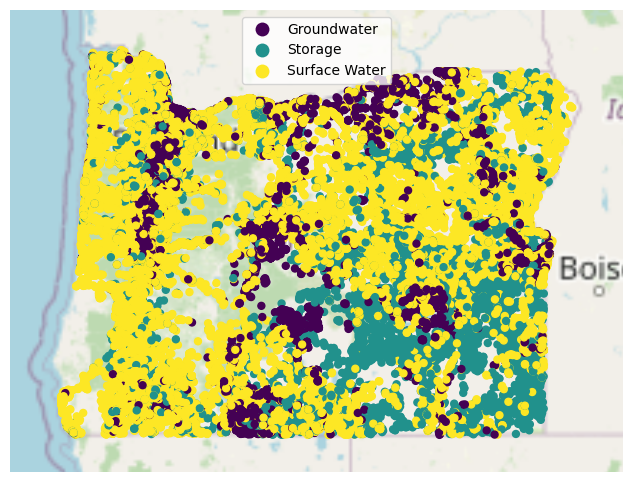

In [11]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs1_ru1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [12]:
# set RegulatoryOverlayUUIDs
gdfs1_ru1['RegulatoryOverlayUUIDs'] = gdfs1_ru1['RegulatoryOverlayUUID']
gdfs1_ru1 = gdfs1_ru1.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs1_ru1.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,ORwr_SPOD10000,ORre_ROor2,ORwr_WSwadeID315,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,45.20715,-123.05841,,,POD,WaDE Blank,POD10000,,well,OR,


#### Regulatory Area Data #2

In [13]:
# dfru2 = dfru.copy()
# etc etc

## Concatenate all Regulatory Area Data Types together
- drop geometry from the wade wr sites.csv geodataframe

In [14]:
# Concatenate dataframes into single output
frames = [dfs, gdfs1_ru1] # list all out dataframes here
outdfs = pd.concat(frames)
outdfs = outdfs.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
outdfs = outdfs.groupby('SiteUUID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem != ""])).replace(np.nan, "").reset_index()
print(len(outdfs))
outdfs.head(1)

193681


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,ORwr_SPOD10000,ORre_ROor2,ORwr_WSwadeID315,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,45.20715210600008,-123.05841099299992,,,POD,WaDE Blank,POD10000,,well,OR,,ORwr_WSwadeID315,Groundwater


# Inspect Output Data & Export

In [15]:
outdfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193681 entries, 0 to 193680
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   SiteUUID                193681 non-null  object
 1   RegulatoryOverlayUUIDs  193681 non-null  object
 2   WaterSourceUUIDs        193681 non-null  object
 3   CoordinateAccuracy      193681 non-null  object
 4   CoordinateMethodCV      193681 non-null  object
 5   County                  193681 non-null  object
 6   EPSGCodeCV              193681 non-null  object
 7   Geometry                193681 non-null  object
 8   GNISCodeCV              193681 non-null  object
 9   HUC12                   193681 non-null  object
 10  HUC8                    193681 non-null  object
 11  Latitude                193681 non-null  object
 12  Longitude               193681 non-null  object
 13  NHDNetworkStatusCV      193681 non-null  object
 14  NHDProductCV            193681 non-n

In [16]:
outdfs

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,ORwr_SPOD10000,ORre_ROor2,ORwr_WSwadeID315,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,45.20715210600008,-123.05841099299992,,,POD,WaDE Blank,POD10000,,well,OR,,ORwr_WSwadeID315,Groundwater
1,ORwr_SPOD100000,ORre_ROor8,ORwr_WSwadeID865,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,45.49223444200004,-117.87363050099998,,,POD,WaDE Blank,POD100000,,stream,OR,,ORwr_WSwadeID865,Surface Water
2,ORwr_SPOD100001,ORre_ROor8,ORwr_WSwadeID865,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,45.52683366200006,-117.88435207199996,,,POD,WaDE Blank,POD100001,,stream,OR,,ORwr_WSwadeID865,Surface Water
3,ORwr_SPOD100002,ORre_ROor8,ORwr_WSwadeID865,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,45.52122747100003,-117.88161490799996,,,POD,WaDE Blank,POD100002,,stream,OR,,ORwr_WSwadeID865,Surface Water
4,ORwr_SPOD100011,ORre_ROor4,ORwr_WSwadeID315,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,45.61262332100006,-121.26713276899994,,,POD,WaDE Blank,POD100011,,well,OR,,ORwr_WSwadeID315,Groundwater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193676,ORwr_SPOU99997,,ORwr_WSwadeID6054,WaDE Blank,WaDE Blank,WaDE Blank,4326,POLYGON ((-123.9044735440188 44.73248046789933...,,,,44.7323816676,-123.904561295,,,POU,WaDE Blank,POU99997,,WaDE Blank,OR,,ORwr_WSwadeID6054,Surface Water
193677,ORwr_SPOU99998_1,,ORwr_WSwadeID48,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,44.5887199454,-123.61761569,,,POU,WaDE Blank,POU99998_1,,WaDE Blank,OR,,ORwr_WSwadeID48,Surface Water
193678,ORwr_SPOU99998_2,,ORwr_WSwadeID15,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,44.5887199454,-123.61761569,,,POU,WaDE Blank,POU99998_2,,WaDE Blank,OR,,ORwr_WSwadeID15,Surface Water
193679,ORwr_SPOU99999_1,,ORwr_WSwadeID48,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,44.5886308513,-123.617347815,,,POU,WaDE Blank,POU99999_1,,WaDE Blank,OR,,ORwr_WSwadeID48,Surface Water


In [17]:
# Export out to CSV.
outdfs.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder